# Dimensionality Reduction

big datasets can have millions of features. Some of these features may be unimportant. for example the pixels around the edge of an instance of the MNIST dataset. others for example may be highly correlated and redcing them together will not loose alot of information. 

Also dimensionality reducting can be very useful reducing a number of features into mabye just 3 dimensions which can then be graphed.

***The three popular dimensions are PCA, kernel and LLE.***

if you picked two points in a unit square the average distance would be roughly 0.52 bit in 1,000,000 dimensions would be around 408.25 which means that it is unlikely any other instance will be replicas and the datasets are at risk of being very sparse meaning all the instances will be very far apart making predictions less reliable than in lower dimensions. In essesnce the more features you have the more prone your model will be to overfitting. Therefore Dimensionality reduction can imporve performance.

##  Projection
in a 3d dataset if you simply project the datapoints onto a single plane you have reduced 3d to 2d however if there are distinct layers in the 3d dataset projecting them ontop of eachother will lose valuable information. 

## Manifold learning
Manifold learning put simply is a 3d shape rolled out onto a 2d plane. a d-dimensional manifold is part of an n-dimensional space where d<n. The manifold hypothesis that many high dimensional datasets resemble closely to a lower dimensional manifold. 

Not all manifolds are simpler than their original spaces. Their decision boundaries may be more complex and therefore it is not always the case that maifold learning will produce a better training set. It depends on the dataset.

## Principle Component Analysis
it is by far the best dimensionality reduction algorithm. It first identifies the hyperplane that lies closest to the data and then projects the data onto it. 

#### Preserving Varience
depending on the hyperplane you use for projection varience will be reduced in some form. This removes some of the important information from the dataset. A dimension must be chosen so that the least amount of varience will be lost. for example if we reduce from 3 to 2 dimensions the dimensions chosen would be the ones that retained the most varience.

Single Value Decomposiition is a matrix factorization method that decomposes the training set. Numpy has a method to find the principle componenets. 


In [1]:
import numpy as np 
from sklearn.datasets import load_digits

train_set = (load_digits())['data']
train_set.shape

(1797, 64)

In [2]:
X_centered = train_set - train_set.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0] #all dimension values for instance 1
c1.shape

(64,)

In [3]:
c2 = Vt.T[:,1] #all dimension values for instance 2 
c2.shape

(64,)

In [4]:
#following code projects the traininset onto the plane defined
# by the first two principle compoenents

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2) #this is how you reduce the dimensionality 
# fo any dataset.
X2D.shape 

(1797, 2)

Using Sklearns PCA class

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
X2D = pca.fit_transform(X_centered)
X2D.shape

(1797, 10)

## Explained Varience Ratio
below shows the level varience that is present in each of the principle componenets in the dataset.

In [6]:
pca.explained_variance_ratio_ 

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.05782411,
       0.04916909, 0.04315969, 0.03661322, 0.03353245, 0.030784  ])

***Choosing the right nubmer of Dimensions***
the general method is to reduce the dimensions to a level that only reduces the total varience to about 0.95. s

In [7]:
pca = PCA()
pca.fit((load_digits())['data'])
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

29

In [8]:
# or 
pca = PCA(n_components=0.95)
data_reduced = pca.fit_transform((load_digits())['data'])
data_reduced.shape

(1797, 29)

# PCA for Compression

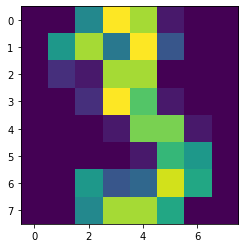

In [9]:
import matplotlib.pyplot as plt
digits = (load_digits())['data']
plt.imshow(digits[3].reshape(8,8))

In [10]:
#lets compress it 
pca = PCA(n_components = 0.95)
im_reduced = pca.fit_transform(digits)
im_reduced[2].shape #down to only 29 components fro 64

(29,)

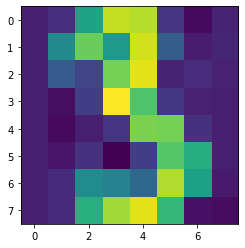

In [11]:
im_reconstructed = pca.inverse_transform(im_reduced)
plt.imshow(im_reconstructed[3].reshape(8,8)) 
# not bad pretty much the same

An issue with the PCA method is that it requires the entire dataset to fit into memory. For large Datasets where this is not possible you must use IPCA algorithm which allows mini-batches for on the fly taining. 

In [12]:
from sklearn.decomposition import IncrementalPCA


n_batches = 60
inc_pca = IncrementalPCA(n_components=29)
for X_batch in np.array_split(digits, n_batches): 
    inc_pca.partial_fit(X_batch)
    
im_reduced = inc_pca.transform(digits)

print('original: ', digits.shape)
print('reduced: ', im_reduced.shape)


original:  (1797, 64)
reduced:  (1797, 29)


# Kernel PCA
we saw in using SVM the rbf kernel method allowed he mapping of a dataset into a higher dimension space (feature space) enabiling nonlinear classification and regression with SVMs. 

remember a linear seperatable datsets in the feature space or complex nonlinear in the original space. The same kernel method can perform complex nonlinear projections for dimensionality reduction.It is good at preserving clusters of instance after projections. 

In [13]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=3, kernel='rbf', gamma=0.4)
dig_reduced = rbf_pca.fit_transform(digits)
dig_reduced.shape

(1797, 3)

# Selecting a Kernel and Tuning Hyperparameters
the kPCA (kernel pca) method is an unsupervised learnin algorithm. There is no obvious performance measure to help you select the best hyperparameter but you could use a grid search to find the best solution and then include that. 

In [14]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 



clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{"kpca__gamma": np.linspace(0.03, 0.05, 10),
               "kpca__kernel": ["rbf", "sigmoid"]}]



grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [16]:
grid_search.best_params_ #the best parameters to use for kPCA.


{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

instead of finding the kernel that produces the best accuracy for the model another method would to find the best hyperparameters that produces the least errors for reconstruction however when you use a kernel method to map a training set into a smaller dimension you effectively first map the training set into a infinate dimensional space and then use PCA to reduce it. It is not therefore possible to be able to map points between sets and not possible to find the error. 

A solution is to find the point in the reduced set that is closest to one in the training set. As they have a relatively large number of dimensions all points are effectively very far away so the close ones are very likely to be the same points in different space. You can then yield the mean squared error and quantify the reconstruction error.

In [17]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)
# by defuatl kernelPCA has fit_inverse_transofrm as false so has 
# no inverse_transform method unless set true.

In [18]:
#compute the pre-image reconstruction error 
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)


1.81663597867971e-26

In [19]:
# lets use gridsearch to find the hyperparameters that reduce 
# the reconstruction error the most.

models = []
param_grid = [{"kpca__gamma": np.linspace(0.03, 0.05, 10),
               "kpca__kernel": ["rbf", "sigmoid"]}]

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

X = load_digits()['data']

for model_kernel in ["rbf", "sigmoid"]:
    for model_gamma in (0.03, 0.05, 10):
        models.append(KernelPCA(n_components=12, kernel=model_kernel,
                               gamma=model_gamma, fit_inverse_transform=True))

model_errors = {}
for model in models: 
    X_reduced = model.fit_transform(X)
    X_preimage = model.inverse_transform(X_reduced)
    print(X.shape, X_preimage.shape)
    model_errors[mean_squared_error(X, X_preimage)] = model


(1797, 64) (1797, 64)
(1797, 64) (1797, 64)
(1797, 64) (1797, 64)
(1797, 64) (1797, 64)
(1797, 64) (1797, 64)
(1797, 64) (1797, 64)


In [20]:

for key in model_errors.keys():
    mini = np.inf
    val = key
    if val<mini: 
        mini = val
        
best_model = model_errors[mini]
best_model

KernelPCA(fit_inverse_transform=True, gamma=10, kernel='sigmoid',
          n_components=12)

In [21]:
mini # better

1.538229973096401e-25

# LLE
Locally Linear Embedding. It is a Manifold Learning technique that does not rely on projections like previous algorithms. 

1. LLE first finds the K-nearest neighbors and then attempts to represent the instance as a linear combination of its neighbors. 

2. do a weighted aggregation of the neighbours to minimize the cost function, where j'th nearest neighbour for point Xi
<br/>
<img src="images/LLE_cost.png")
<br/>
 
3. Now that we have the weights ***W*** that minimized the cost function above and encodes the local linear relationships between instances. The next step is to map the instances into a d-dimensional space d<n while preserving local relationships.

4. next we minimize the folowing. 
<img src="images/LLE_step_two.png">

where ***Z*** is the image of ***X*** in d dimensions. It looks similar to the first optimization but instead of keeping the instances fixing and findng the optimal weights. Keep the weights fixed and find the optimal position of the instances int he lower dimensional space.

5. LLE has the complexity O(m log(m)n log(k)) for finding k nearest neighbors, O(mnk^3) for optimizing weights and O(dm^2) for constructing low-dimensional representations. The m^2 in the last term makes the alogrithm scale poorly to large datasets.